# Training an MLP on Time Series Data
This notebook demonstrates how to train a Multi-Layer Perceptron (MLP) on synthetic time series data using the ThreeWToolkit, for the time series regression task.

In [1]:
import sys
import os
import numpy as np

# Adiciona o diretório raiz ao sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../')))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from tqdm import tqdm
from pathlib import Path
from ThreeWToolkit.preprocessing import normalize, windowing
from ThreeWToolkit.trainer.trainer import ModelTrainer, TrainerConfig
from ThreeWToolkit.models.mlp import MLPConfig
from ThreeWToolkit.dataset import ParquetDataset
from ThreeWToolkit.core.base_dataset import ParquetDatasetConfig

In [3]:
# dataset_path = Path("dataset")
dataset_path = Path("../../data/raw/")

# create and load
ds_config = ParquetDatasetConfig(
    path=dataset_path, clean_data=True, download=False, target_class=[0, 1, 2]
)

ds = ParquetDataset(ds_config)
ds[19]
len(ds)


760

In [4]:
window_size = 1000
mlp_config = MLPConfig(
    input_size=window_size,
    hidden_sizes=(32, 16),
    output_size=3,
    random_seed=11,
    activation_function="relu",
    regularization=None,
)

trainer_config = TrainerConfig(
    optimizer="adam",
    criterion="cross_entropy",
    batch_size=32,
    epochs=20,
    seed=11,
    config_model=mlp_config,
    learning_rate=0.001,
    device="cuda" if torch.cuda.is_available() else "cpu",
    cross_validation=False,
    shuffle_train=True
)

trainer = ModelTrainer(trainer_config)
print(trainer.model)

MLP(
  (activation_func): ReLU()
  (model): Sequential(
    (0): Linear(in_features=1000, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=3, bias=True)
  )
)


In [5]:
ds[0]["signal"].columns

Index(['ABER-CKGL', 'ABER-CKP', 'ESTADO-DHSV', 'ESTADO-M1', 'ESTADO-M2',
       'ESTADO-PXO', 'ESTADO-SDV-GL', 'ESTADO-SDV-P', 'ESTADO-W1', 'ESTADO-W2',
       'ESTADO-XO', 'P-ANULAR', 'P-JUS-CKGL', 'P-JUS-CKP', 'P-MON-CKP',
       'P-PDG', 'P-TPT', 'QGL', 'T-JUS-CKP', 'T-MON-CKP', 'T-PDG', 'T-TPT'],
      dtype='object')

In [ ]:
selected_col = "T-TPT"
n_events = 25
x_train = []
y_train = []
dfs = []

for event in tqdm(ds):
    #normalized_signal = normalize(event["signal"][selected_col])
    windowed_signal = windowing(
        event["signal"][selected_col],
        window="hann",
        window_size=window_size,
        overlap=0.5,
        pad_last_window=True,
    )
    windowed_signal.drop(columns=["win"], inplace=True)
    windowed_signal["label"] = np.unique(event["label"]["class"])[0]
    dfs.append(windowed_signal)

100%|██████████| 760/760 [01:03<00:00, 12.00it/s]


In [7]:
dfs_final = pd.concat(dfs, ignore_index=True, axis=0)

In [8]:
dfs_final


,val_1,val_2,val_3,val_4,val_5,val_6,val_7,val_8,val_9,val_10,...,val_992,val_993,val_994,val_995,val_996,val_997,val_998,val_999,val_1000,label
0,0.0,0.000007,0.000029,0.000065,0.000115,0.000179,0.000258,0.000351,0.000459,0.000580,...,0.000581,0.000459,0.000351,0.000258,0.000179,0.000115,0.000065,0.000029,0.000007,0
1,0.0,0.000007,0.000029,0.000065,0.000115,0.000179,0.000258,0.000351,0.000459,0.000580,...,0.000581,0.000459,0.000351,0.000258,0.000179,0.000115,0.000065,0.000029,0.000007,0
2,0.0,0.000007,0.000029,0.000065,0.000115,0.000179,0.000258,0.000351,0.000459,0.000581,...,0.000581,0.000459,0.000351,0.000258,0.000179,0.000115,0.000065,0.000029,0.000007,0
3,0.0,0.000007,0.000029,0.000065,0.000115,0.000179,0.000258,0.000351,0.000459,0.000581,...,0.000581,0.000459,0.000351,0.000258,0.000179,0.000115,0.000065,0.000029,0.000007,0
4,0.0,0.000007,0.000029,0.000065,0.000115,0.000179,0.000258,0.000351,0.000459,0.000581,...,0.000581,0.000459,0.000351,0.000258,0.000179,0.000115,0.000065,0.000029,0.000007,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44390,-0.0,-0.000027,-0.000108,-0.000242,-0.000430,-0.000672,-0.000968,-0.001317,-0.001720,-0.002177,...,-0.002253,-0.001780,-0.001363,-0.001001,-0.000696,-0.000445,-0.000250,-0.000111,-0.000028,2
44391,-0.0,-0.000027,-0.000110,-0.000247,-0.000439,-0.000686,-0.000987,-0.001344,-0.001755,-0.002221,...,-0.002280,-0.001802,-0.001380,-0.001014,-0.000704,-0.000451,-0.000253,-0.000113,-0.000028,2
44392,-0.0,-0.000028,-0.000111,-0.000250,-0.000445,-0.000696,-0.001002,-0.001364,-0.001781,-0.002254,...,-0.002304,-0.001821,-0.001394,-0.001024,-0.000711,-0.000455,-0.000256,-0.000114,-0.000028,2
44393,-0.0,-0.000028,-0.000113,-0.000254,-0.000451,-0.000704,-0.001014,-0.001380,-0.001803,-0.002282,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2


In [9]:
dfs_final["label"].value_counts()

label
0    24633
1    18267
2     1495
Name: count, dtype: int64

In [10]:
# Train the MLP model using the new ModelTrainer interface
trainer.train(x_train=dfs_final.iloc[:, :-1], y_train=dfs_final["label"].astype(int))

In [11]:
# Evaluate model performance on validation set using ModelTrainer's test method
from ThreeWToolkit.metrics import accuracy_score, recall_score

test_loss, test_metrics = trainer.test(
    dfs_final.iloc[:, :-1], dfs_final["label"].astype(int), metrics=[
        accuracy_score,
        lambda y_true, y_pred: recall_score(y_true, y_pred, average='weighted')
    ]
)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Metrics: {test_metrics}")

Test Loss: 0.1960
Test Metrics: {'accuracy_score': 0.9547021060930285, '<lambda>': 0.9547021060930285}


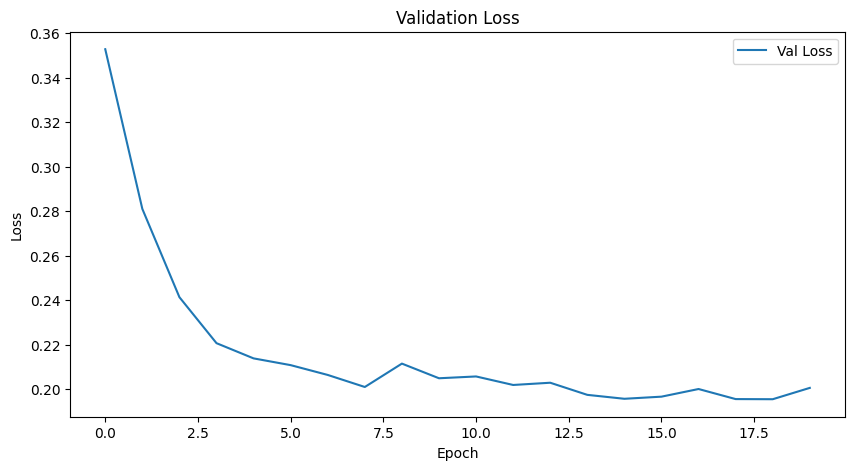

In [12]:
# Visualize training history
plt.figure(figsize=(10, 5))
for i, fold_hist in enumerate(trainer.history):
    if fold_hist is not None:
        plt.plot(fold_hist["val_loss"], label="Val Loss")
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

**FIM** : Matheus

__________

In [ ]:
# # Example: Setup TrainerConfig with Kfold for cross-validation
# from sklearn.metrics import mean_squared_error, r2_score

# trainer_config_cv = TrainerConfig(
#     optimizer="adam",
#     criterion="mse",
#     batch_size=16,
#     epochs=100,
#     seed=11,
#     config_model=mlp_config,
#     learning_rate=0.001,
#     device="cuda" if torch.cuda.is_available() else "cpu",
#     cross_validation=True,
#     n_splits=5,
#     metrics=[mean_squared_error, r2_score],
# )
# trainer_cv = ModelTrainer(trainer_config_cv)

In [ ]:
# Train the MLP model using cross-validation (StratifiedKFold)
# This will run 5-fold cross-validation and store history for each fold in trainer_cv.history


# trainer_cv.train(X_train_tensor, y_train_tensor)

Training fold 1/5


Training fold 2/5


Training fold 3/5


Training fold 4/5


Training fold 5/5


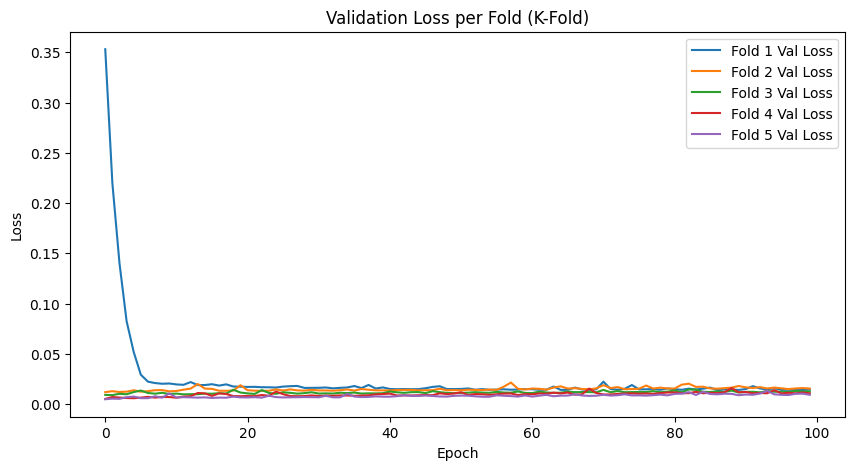

In [ ]:
# Visualize K-Fold training history for all folds
# plt.figure(figsize=(10, 5))
# for i, fold_hist in enumerate(trainer_cv.history):
#     if fold_hist is not None:
#         plt.plot(fold_hist["val_loss"], label=f"Fold {i + 1} Val Loss")
# plt.title("Validation Loss per Fold (K-Fold)")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.legend()
# plt.show()